<a href="https://colab.research.google.com/github/daniloaleixo/UdacityMachineLearningTrading/blob/master/Strategy_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Backtesting strategy - II : Intraday resistance breakout strategy

Trading with resistance breakout

* Breakout rule: breach 20 period rolling max/min price in conjunction with volume breaching rolling max volume 
* Exit/stop loss signal: Previous price plus/minus 20 period ATR as the rolling stop loss price 

In [0]:
# =============================================================================
# Backtesting strategy - II : Intraday resistance breakout strategy
# Author : Mayank Rasu

# Please report bug/issues in the Q&A section
# =============================================================================

In [3]:
!pip install alpha_vantage

  Created wheel for alpha-vantage: filename=alpha_vantage-2.1.3-cp36-none-any.whl size=14870 sha256=7e4d1dd759059a1ee6cf3cac89f24a170da5497df64817efc75551fe7aa75d27
  Stored in directory: /root/.cache/pip/wheels/d4/75/c2/483b0a988fd965b1128c1396a0ffadfb8903bd2bb569220048
Successfully built alpha-vantage


In [0]:
import numpy as np
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import copy
import pathlib

In [0]:
def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Adj Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2['ATR']

def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*78)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*78)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

In [20]:
# Download historical data (monthly) for selected stocks

tickers = ["MSFT","AAPL","FB","AMZN","INTC", "CSCO","VZ","IBM","QCOM","LYFT"]

ohlc_intraday = {} # directory with ohlc value for each stock            
key_path = "key.text"
ts = TimeSeries(key=open(str(pathlib.Path().absolute()) + "/" + key_path,'r').read(), output_format='pandas')

attempt = 0 # initializing passthrough variable
drop = [] # initializing list to store tickers whose close price was successfully extracted
while len(tickers) != 0 and attempt <=5:
    tickers = [j for j in tickers if j not in drop]
    for i in range(len(tickers)):
        try:
            ohlc_intraday[tickers[i]] = ts.get_intraday(symbol=tickers[i],interval='5min', outputsize='full')[0]
            ohlc_intraday[tickers[i]].columns = ["Open","High","Low","Adj Close","Volume"]
            drop.append(tickers[i])      
        except:
            print(tickers[i]," :failed to fetch data...retrying")
            continue
    attempt+=1

 
tickers = ohlc_intraday.keys() # redefine tickers variable after removing any tickers with corrupted data

CSCO  :failed to fetch data...retrying
VZ  :failed to fetch data...retrying
IBM  :failed to fetch data...retrying
QCOM  :failed to fetch data...retrying
LYFT  :failed to fetch data...retrying
CSCO  :failed to fetch data...retrying
VZ  :failed to fetch data...retrying
IBM  :failed to fetch data...retrying
QCOM  :failed to fetch data...retrying
LYFT  :failed to fetch data...retrying
CSCO  :failed to fetch data...retrying
VZ  :failed to fetch data...retrying
IBM  :failed to fetch data...retrying
QCOM  :failed to fetch data...retrying
LYFT  :failed to fetch data...retrying
CSCO  :failed to fetch data...retrying
VZ  :failed to fetch data...retrying
IBM  :failed to fetch data...retrying
QCOM  :failed to fetch data...retrying
LYFT  :failed to fetch data...retrying
CSCO  :failed to fetch data...retrying
VZ  :failed to fetch data...retrying
IBM  :failed to fetch data...retrying
QCOM  :failed to fetch data...retrying
LYFT  :failed to fetch data...retrying
CSCO  :failed to fetch data...retrying
V

## Backtesting

In [36]:
# calculating ATR and rolling max price for each stock and consolidating this info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}
for ticker in tickers:
    print("calculating ATR and rolling max price for ",ticker)
    ohlc_dict[ticker]["ATR"] = ATR(ohlc_dict[ticker],20)
    ohlc_dict[ticker]["roll_max_cp"] = ohlc_dict[ticker]["High"].rolling(20).max()
    ohlc_dict[ticker]["roll_min_cp"] = ohlc_dict[ticker]["Low"].rolling(20).min()
    ohlc_dict[ticker]["roll_max_vol"] = ohlc_dict[ticker]["Volume"].rolling(20).max()
    ohlc_dict[ticker].dropna(inplace=True)
    tickers_signal[ticker] = ""
    tickers_ret[ticker] = []

calculating ATR and rolling max price for  MSFT
calculating ATR and rolling max price for  AAPL
calculating ATR and rolling max price for  FB
calculating ATR and rolling max price for  AMZN
calculating ATR and rolling max price for  INTC


In [37]:
# identifying signals and calculating daily return (stop loss factored in)
for ticker in tickers:
    print("calculating returns for ",ticker)
    for i in range(len(ohlc_dict[ticker])):
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
        
        elif tickers_signal[ticker] == "Buy":
            if ohlc_dict[ticker]["Adj Close"][i]<ohlc_dict[ticker]["Adj Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append(((ohlc_dict[ticker]["Adj Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1])/ohlc_dict[ticker]["Adj Close"][i-1])-1)
            elif ohlc_dict[ticker]["Low"][i]<=ohlc_dict[ticker]["roll_min_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Sell"
                tickers_ret[ticker].append(((ohlc_dict[ticker]["Adj Close"][i-1] - ohlc_dict[ticker]["ATR"][i-1])/ohlc_dict[ticker]["Adj Close"][i-1])-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Adj Close"][i]/ohlc_dict[ticker]["Adj Close"][i-1])-1)
                
        elif tickers_signal[ticker] == "Sell":
            if ohlc_dict[ticker]["Adj Close"][i]>ohlc_dict[ticker]["Adj Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]:
                tickers_signal[ticker] = ""
                tickers_ret[ticker].append((ohlc_dict[ticker]["Adj Close"][i-1]/(ohlc_dict[ticker]["Adj Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]))-1)
            elif ohlc_dict[ticker]["High"][i]>=ohlc_dict[ticker]["roll_max_cp"][i] and \
               ohlc_dict[ticker]["Volume"][i]>1.5*ohlc_dict[ticker]["roll_max_vol"][i-1]:
                tickers_signal[ticker] = "Buy"
                tickers_ret[ticker].append((ohlc_dict[ticker]["Adj Close"][i-1]/(ohlc_dict[ticker]["Adj Close"][i-1] + ohlc_dict[ticker]["ATR"][i-1]))-1)
            else:
                tickers_ret[ticker].append((ohlc_dict[ticker]["Adj Close"][i-1]/ohlc_dict[ticker]["Adj Close"][i])-1)
                
    ohlc_dict[ticker]["ret"] = np.array(tickers_ret[ticker])

calculating returns for  MSFT
calculating returns for  AAPL
calculating returns for  FB
calculating returns for  AMZN
calculating returns for  INTC


In [0]:
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_dict[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)

In [39]:
print("CAGR: ", CAGR(strategy_df)*100, "% -- sharpe: ", sharpe(strategy_df,0.025), " -- dd: ", max_dd(strategy_df)*100, "%")  

CAGR:  -35.82510390364768 % -- sharpe:  -4.530798605198006  -- dd:  4.470511069222871 %


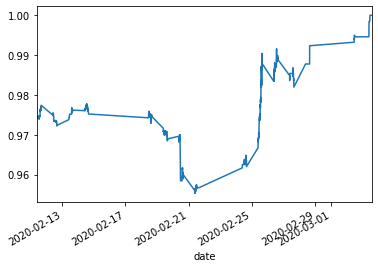

In [40]:
# vizualization of strategy return
(1+strategy_df["ret"]).cumprod().plot()

In [35]:
#calculating individual stock's KPIs
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
for ticker in tickers:
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_dict[ticker])
    sharpe_ratios[ticker] =  sharpe(ohlc_dict[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_dict[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown],index=["Return","Sharpe Ratio","Max Drawdown"])      
KPI_df.T

calculating KPIs for  MSFT
calculating KPIs for  AAPL
calculating KPIs for  FB
calculating KPIs for  AMZN
calculating KPIs for  INTC


,Return,Sharpe Ratio,Max Drawdown
MSFT,-0.708936,-4.887835,0.090970
AAPL,-0.368211,-3.078837,0.057724
FB,-0.123163,-1.107338,0.047182
AMZN,-0.059256,-0.631870,0.032651
INTC,-0.308164,-1.802161,0.043940
